In [82]:
import nibabel as nib #pip install nibabel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import os.path as op
# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm
import os
from scipy.stats import zscore
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_roi
from nilearn.plotting import plot_prob_atlas
from nilearn import image
from nilearn.image import  resample_to_img
from sklearn.decomposition import PCA, FastICA

%matplotlib inline

#### Struture of the data
In this project, we work with [the Alice dataset](https://openneuro.org/datasets/ds002322/versions/1.0.4). With the following functions, you will have the following folder's structure.
```
├───sub_18
│   ├───anat
│   ├───derivatives
│   └───func
├───sub_22
│   ├───anat
│   ├───derivatives
│   └───func
└───sub_35
    ├───anat
    ├───derivatives
    └───func
```

In [83]:
class DownloadProgressBar(tqdm):
    '''
    This class is used to download the dataset and display the progress of the download in the console.
    '''
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    '''
    This function is used to download the files from the link.
    '''
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(dataset_id, dataset_version, subject_fmap):
    '''
    The called items should follow the following format:
    dataset_id = 'ds004226'
    dataset_version = '1.0.0'
    subject_fmap = '18'
    
    The dataset used for this mini-project can be found at the following link:
    https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    '''
    subject = 'sub-' + subject_fmap
    folder_name = ['anat', 'func', 'derivatives']
    file = [f'sub-{subject_fmap}_T1w.nii.gz', 
            f'sub-{subject_fmap}_task-alice_bold.nii.gz',
            f'sub-{subject_fmap}_task-alice_bold_preprocessed.nii.gz']
    
    paths = [[str(subject), str(folder_name[0]), str(file[0])],
            [str(subject), str(folder_name[1]), str(file[1])],
            [str(folder_name[2]), str(subject), str(file[2])]]
    
    # Because of the fact that the derivative folder requires a different link, we need to create this table, and we can't dynamically extract the folder's names
    # (again because of their differents positions), so we also need the table 'file'. If they all had the same, the code would be much shorter.
    
    path_subject = op.join(os. getcwd(), 'sub_'+subject_fmap)  
    
    if not op.isdir(path_subject): # If the subject's folder doesn't exists, we create it
        os.makedirs(path_subject)
    
    for i in range(len(folder_name)):
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, *paths[i])
        folders_path = op.join(path_subject, folder_name[i])
        if not os.path.exists(folders_path):  # if the folder doesn't already exists, we create it and download the corresponding content
            os.makedirs(folders_path) 
            print('Attempting download from ', download_link)
            download_url(download_link, op.join(folders_path, file[i]))
            print('Ok')



In [84]:
dataset_fmap = 'ds002322'
subject_fmap = ('18','22','23', '24', '26', '28', '30', '31', '35', '36')

# Download one subject's data from each dataset
for i in subject_fmap:
    print('Starting the downloads for the subject sub-{}'.format(i))
    direct_file_download_open_neuro(dataset_id = dataset_fmap,
                                    dataset_version='1.0.4',
                                    subject_fmap = i)

Starting the downloads for the subject sub-18
Starting the downloads for the subject sub-22
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/derivatives:sub-22:sub-22_task-alice_bold_preprocessed.nii.gz


derivatives:sub-22:sub-22_task-alice_bold_preprocessed.nii.gz: 289MB [02:26, 1.98MB/s]                               


Ok
Starting the downloads for the subject sub-35
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/derivatives:sub-35:sub-35_task-alice_bold_preprocessed.nii.gz


derivatives:sub-35:sub-35_task-alice_bold_preprocessed.nii.gz: 291MB [04:48, 1.01MB/s]                               

Ok


### Load the data


In [85]:
current_directory = os.getcwd()
individual = '18'

# Load the data
img = nib.load(current_directory + '/sub_'+individual +'/derivatives/sub-'+individual+'_task-alice_bold_preprocessed.nii.gz')
data = np.asanyarray(img.dataobj)
print(data.shape)

FileNotFoundError: No such file or no access: 'c:\Users\emy8\OneDrive\Documents\EPFL\Master\MA3\NSSP\NSSP_421_Group_M\Project2/sub_18/derivatives/sub-18_task-alice_bold_preprocessed.nii.gz'

### Extract meaningful caracteristcs of the data

In [ ]:
# Extract the size of the data
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]
print(vol_shape, n_vols)

(79, 95, 68) 372


In [ ]:
# Get the number of voxels
N = np.prod(vol_shape)

# We take the full matrix as time series
data_ = data.reshape(N, n_vols).T

# Reshape in function of the time axis and take the transpose
print(data_.shape)

(372, 510340)


In [ ]:
# To get the PCA need the row means in a times_axis_shape x N
row_means = np.mean(data_, axis=1)
row_means = np.outer(row_means, np.ones(N))

# Substract the mean from the time axis
X = data_ - row_means

print("Mean of means left after centering: ", np.mean(np.mean(X, axis=1)))

Mean of means left after centering:  -9.983021225057745e-16


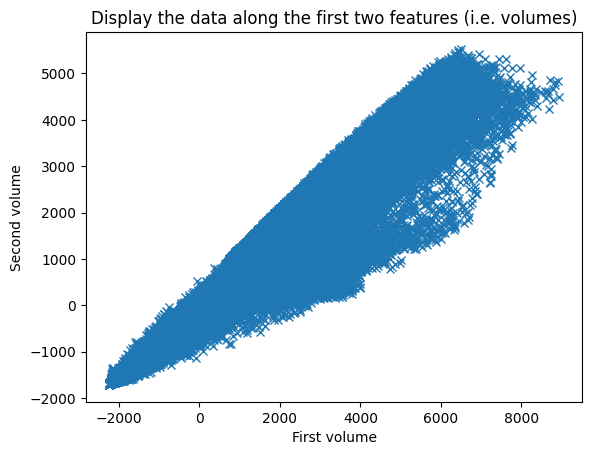

In [ ]:
plt.plot(X[0], X[1], 'x')
plt.xlabel("First volume")
plt.ylabel("Second volume")
plt.title('Display the data along the first two features (i.e. volumes)')
plt.show()

### PCA 

In [ ]:
# Compute the covariance matrix
covariance_matrix = np.cov(X)

# Get the U, S, VT matrices
U, S, VT = np.linalg.svd(covariance_matrix)

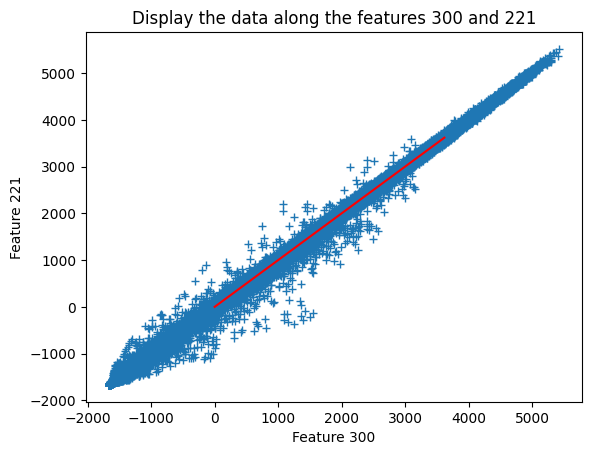

In [ ]:
# Plot the signal in the first row against signal in the second row

# Choose which features to plot
feature1 = 300
feature2 = 221

plt.plot(X[feature1], X[feature2], '+')
scaled_u = U[:, 0] * -70000
plt.plot([0, scaled_u[feature1]], [0, scaled_u[feature2]], 'r')
plt.xlabel("Feature {}".format(feature1))
plt.ylabel("Feature {}".format(feature2))
plt.title('Display the data along the features {} and {}'.format(feature1, feature2))
plt.show()

In [ ]:
# Scalar projection
C = U.T.dot(X)

C_vols = C.T.reshape(vol_shape + (n_vols,))

# Break 4D array in 3D
vol0 = C_vols[..., 0]
vol1 = C_vols[..., 1]

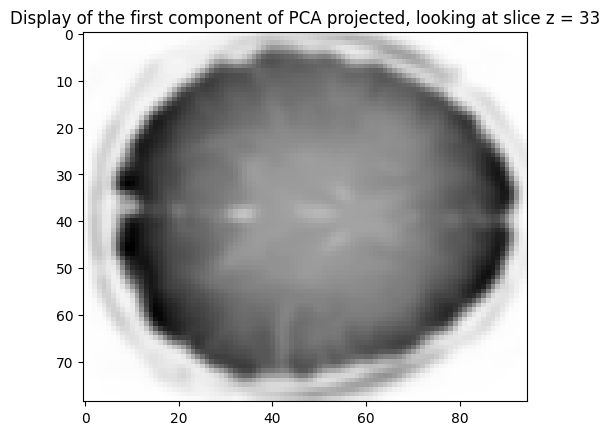

In [ ]:
mid_z = int(vol0.shape[2]/2) - 1
plt.imshow(vol0[:, :, mid_z], cmap='gray')
plt.title("Display of the first component of PCA projected, looking at slice z = {}".format(mid_z))
plt.show()

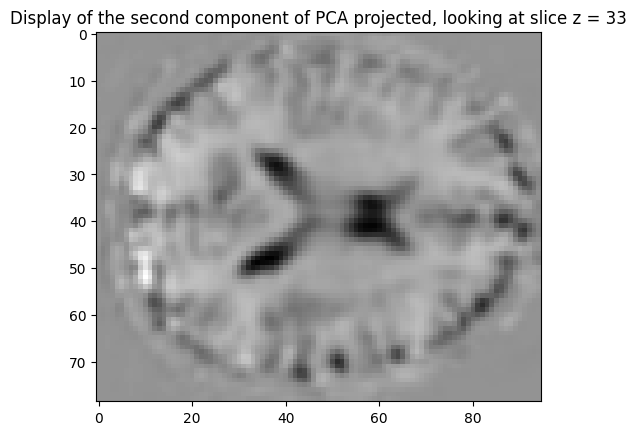

In [ ]:
mid_z = int(vol1.shape[2]/2) - 1
plt.imshow(vol1[:, :, mid_z], cmap='gray')
plt.title("Display of the second component of PCA projected, looking at slice z = {}".format(mid_z))
plt.show()

### Spatial Group ICA

In [ ]:
# Load first subject to use as basics for the next part
dataset_fmap = 'ds002322'
subject_fmap = ('18','22','35')

current_directory = os.getcwd()
individual = '18'
img = nib.load(current_directory + '/sub_'+individual +'/derivatives/sub-'+individual+'_task-alice_bold_preprocessed.nii.gz')
affine = img.affine

In [ ]:
#find x,y,z shapes on functional data of first subject

print("Shape of image ", img.shape, "\n")
x,y,z,vol = img.shape

# Remove the first volumes of each subject to avoid false correlation
discarded_data = 5

N_vol = 372
N_subj = 3
N_tot = (N_vol-discarded_data)* N_subj

X = np.zeros((N_tot, x*y*z))
i = 0
n_nii = 0
nb_subj_counted = 0
for n_nii in range(N_subj):
    print('Loading subject ', n_nii+1)
    img = nib.load(current_directory + '/sub_'+subject_fmap[n_nii] +'/derivatives/sub-'+subject_fmap[n_nii]+'_task-alice_bold_preprocessed.nii.gz')
    data = np.asanyarray(img.dataobj)
    for j in range(N_vol-discarded_data):
        X[i] = data[:, :, :, j+discarded_data].reshape(x*y*z)
        i += 1
        
print("\n" + "Number of used vol ", int(X.shape[0]/N_subj))

print("\n" + "Finished loading ✅")

X = zscore(X, axis=1)
X = np.nan_to_num(X,0)


Shape of image  (79, 95, 68, 372) 

Loading subject  1
Loading subject  2
Loading subject  3

Number of used vol  367

Finished loading ✅


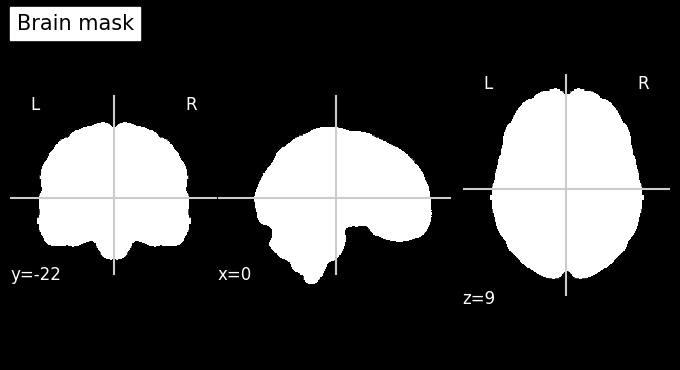

In [ ]:
icbms = datasets.fetch_icbm152_2009()
masker = NiftiMasker(mask_img=icbms.mask)
plot_stat_map(icbms.mask, title='Brain mask',black_bg=True, colorbar=False)

In [ ]:
S_dict = {}
n_components = [1, 3, 10, 20, 40, 100]
min_pca_components = 20

for i in n_components:
    
    n2= max(2*i, min_pca_components)
    print('Running PCA with n = %d components 💁‍♂️'%n2)
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)
    print('Running FastICA with n = %d components 🏃'%i)

    ica = FastICA(n_components=i,random_state=1)
    S_ = ica.fit_transform(H)

    S_dict[i]=S_
    print('Done ✌️')

Running PCA with n = 2 components 💁‍♂️
Running FastICA with n = 1 components 🏃
Done ✌️
Running PCA with n = 6 components 💁‍♂️
Running FastICA with n = 3 components 🏃
Done ✌️
Running PCA with n = 20 components 💁‍♂️
Running FastICA with n = 10 components 🏃
Done ✌️
Running PCA with n = 40 components 💁‍♂️
Running FastICA with n = 20 components 🏃
Done ✌️
Running PCA with n = 80 components 💁‍♂️
Running FastICA with n = 40 components 🏃
Done ✌️
Running PCA with n = 200 components 💁‍♂️
Running FastICA with n = 100 components 🏃
Done ✌️


In [ ]:
# Loading T1 image as a background
T1_img = icbms.t1 

Plotting for n = 1 components
Plotting for n = 3 components
Plotting for n = 10 components
Plotting for n = 20 components
Plotting for n = 40 components
Plotting for n = 100 components


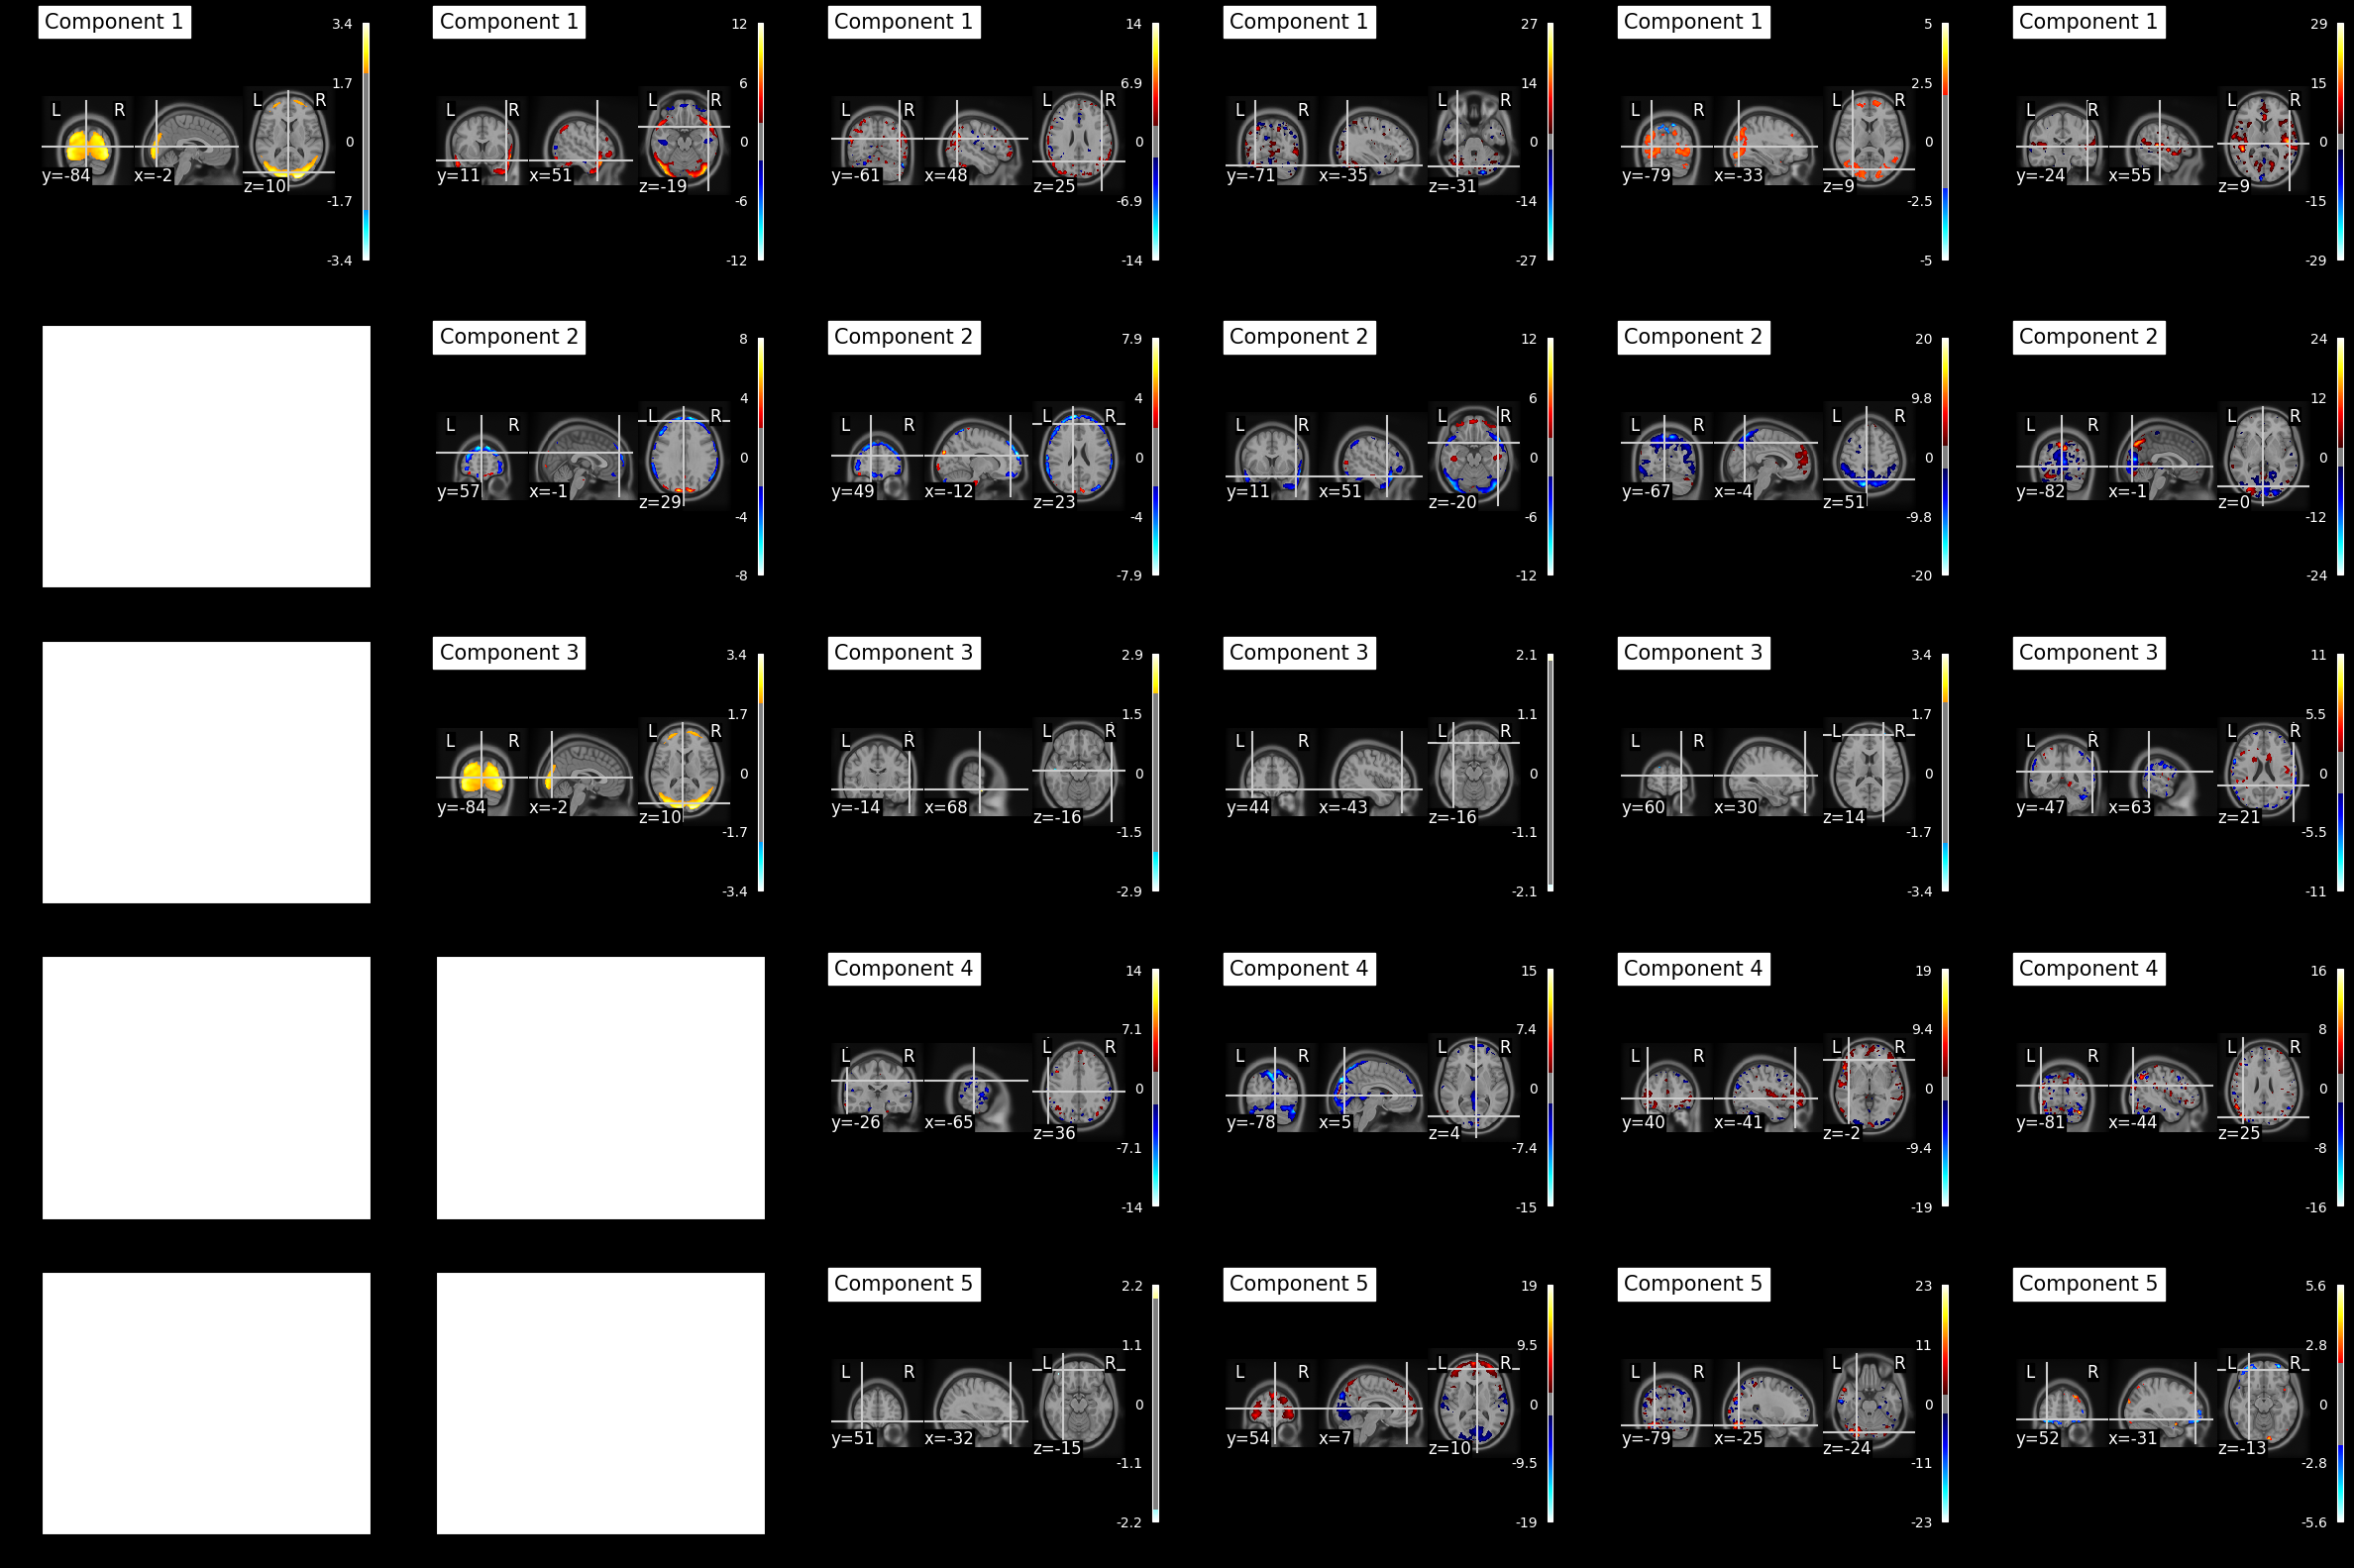

In [ ]:
# Plot the ground level components for the different number of components, limited to the first 5 components
n_row = 5
fig, axes = plt.subplots(nrows = n_row, ncols = len(n_components),figsize=(30, 20), facecolor="k", edgecolor="k") 
# gs = gridspec.GridSpec(n_row, 3, width_ratios=[1, 1, 1])

for j, i in enumerate(n_components):
    print('Plotting for n = %d components'%i)
    #axes[0, j].set_title('%d components'%i, fontsize=20, color="white")
    S_ = S_dict[i].copy()
    for idx, s in enumerate(S_.T[:(min(n_row, S_.T.shape[0]))]):
        s_img = nib.Nifti1Image(s.reshape(x,y,z), affine)
        s_img_resampled = resample_to_img(s_img, T1_img, interpolation='linear')
        data_mask = masker.fit_transform(s_img_resampled)
        masked = masker.inverse_transform(data_mask)
        plot_stat_map(masked, title='Component %d'%(idx+1),black_bg=True, colorbar=True, bg_img=T1_img, display_mode='ortho', threshold=2*np.std(s), axes=axes[idx, j])

In [ ]:
atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")

c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\nilearn\image\resampling.py:591: UserWarning: Casting data from int16 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


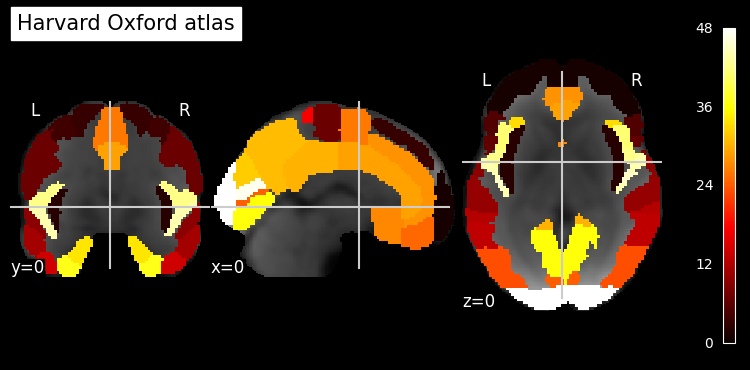

In [ ]:
# Load the data
#img = nib.load(current_directory + '/sub_'+individual +'/derivative/sub-'+individual+'_task-alice_bold_preprocessed.nii.gz')
#data = np.asanyarray(img.dataobj)
bg_data = data[..., 20] # ignore the first 5 volumes at least


s_img = nib.Nifti1Image(bg_data, affine)
s_img_data = masker.fit_transform(s_img)
bg_masked = masker.inverse_transform(s_img_data)

plot_stat_map(atlas.maps, title='Harvard Oxford atlas',black_bg=True, colorbar=True, bg_img=bg_masked, display_mode='ortho', threshold=0.1, cut_coords=(0, 0, 0))

In [ ]:
# Downsample bg_masked to the size of atlas_harvard.maps, with s_img for each component of interest
bg_masked_resampled = image.resample_img(bg_masked, target_affine=atlas.maps.affine, target_shape=atlas.maps.shape)

c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\nilearn\plotting\displays\_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


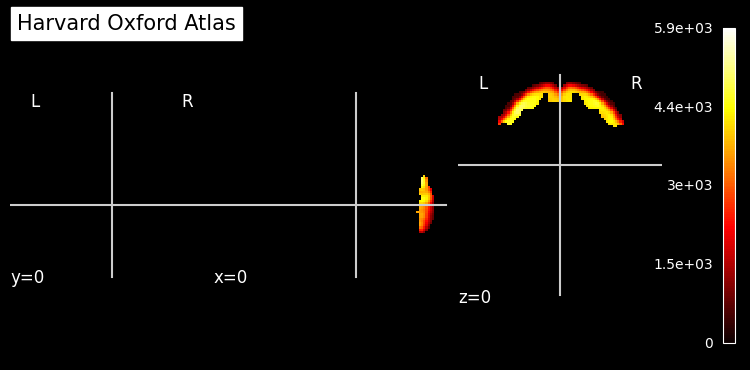

In [ ]:
# Create black image for background purposes
dark_bg = np.zeros(atlas.maps.shape)
dark_bg_img = nib.Nifti1Image(dark_bg, atlas.maps.affine)

# Get an array of the region 0
region0 = atlas.maps.get_fdata() == 1

# Turn previously sampled image into an array
data_tmp = bg_masked_resampled.get_fdata()

# Could here binarize data_tmp, for example by keeping only values > std(s_img)
# this could be used as a mask on atlas_harvard.maps.get_fdata(), to get the number of regions activated by the component

# Keep from the data only part where the mask is true
data_tmp[~region0] = 0

# recreate an image for plotting
tmp_img = nib.Nifti1Image(data_tmp, atlas.maps.affine)

plot_stat_map(tmp_img, title='Harvard Oxford Atlas',black_bg=True, colorbar=True, bg_img=dark_bg_img, display_mode='ortho', threshold=0.1, cut_coords=(0, 0, 0))
plt.show()

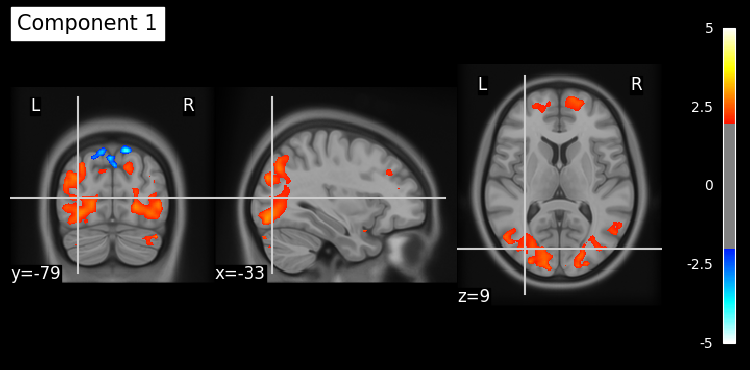

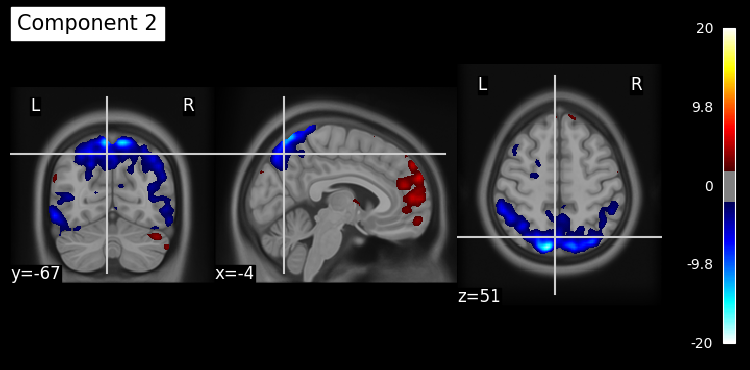

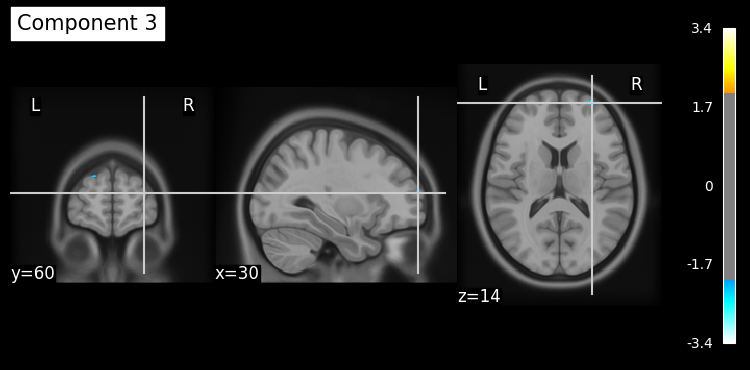

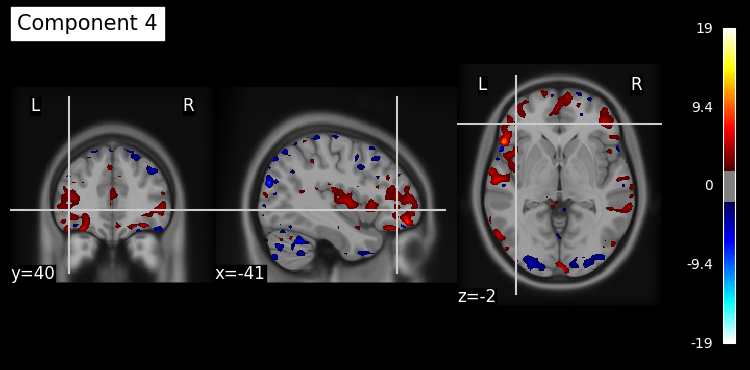

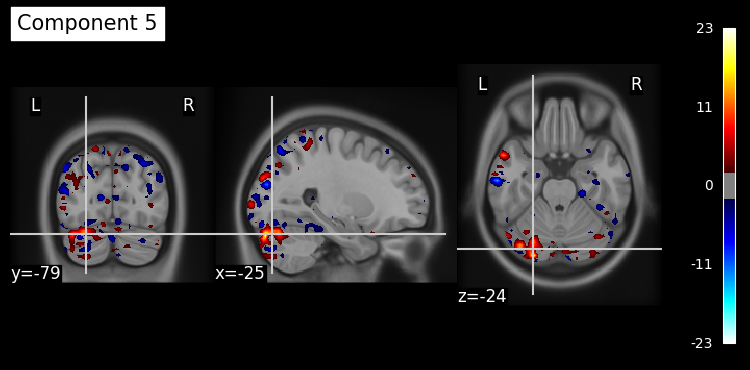

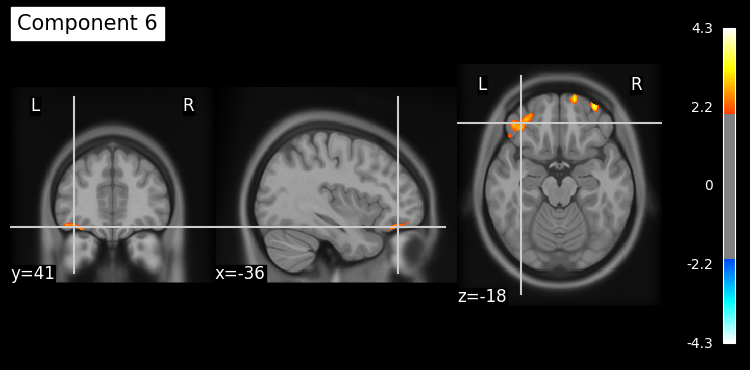

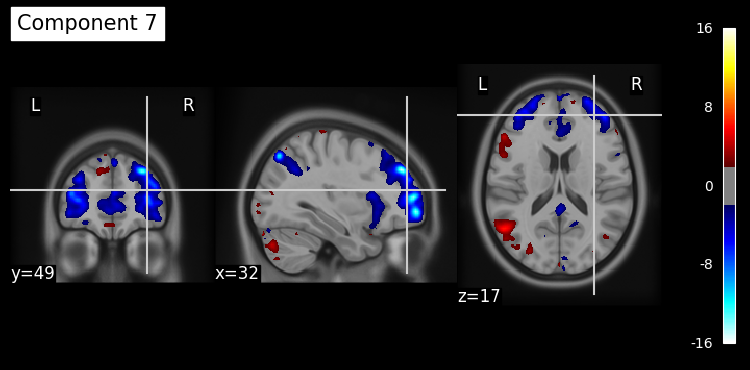

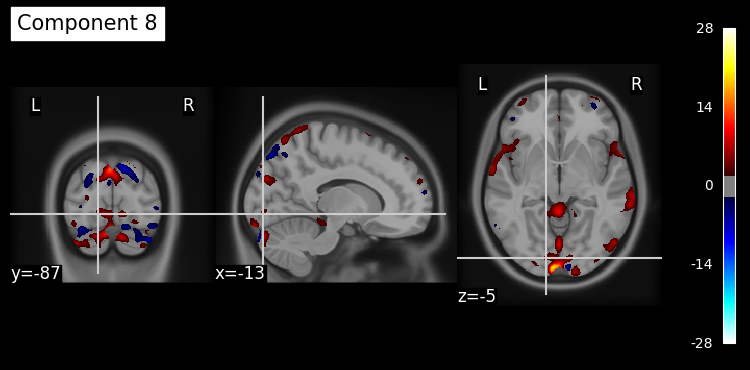

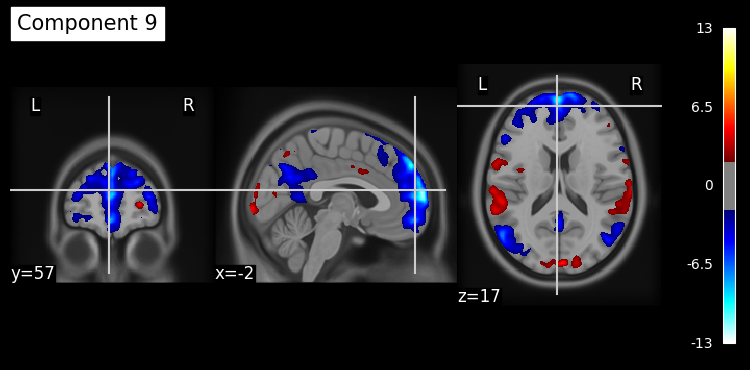

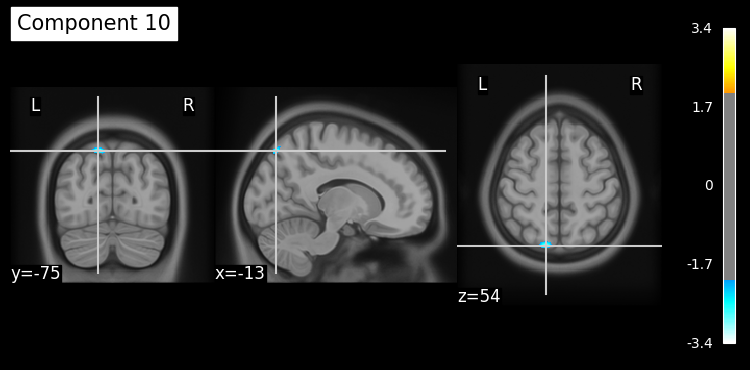

In [ ]:
# Get the analysis for the 10 first components
for i in range(10):
    s = S_dict[40].T[i]
    s_img_temp = nib.Nifti1Image(s.reshape(x,y,z), affine)
    s_img_resampled_temp = resample_to_img(s_img_temp, T1_img, interpolation='linear')
    data_mask_temp = masker.fit_transform(s_img_resampled_temp)
    masked_temp = masker.inverse_transform(data_mask_temp)
    plot_stat_map(masked_temp, title='Component %d'%(i+1),black_bg=True, colorbar=True, bg_img=T1_img, display_mode='ortho', threshold=2*np.std(s))

In [ ]:
comp5 = S_dict[40].T[8]
s_comp5 = nib.Nifti1Image(comp5.reshape(x,y,z), affine)
s_comp5_data = masker.fit_transform(s_comp5)
comp5_bg_masked = masker.inverse_transform(s_comp5_data)
# Check the sizes
print(atlas.maps.shape)
print(comp5_bg_masked.shape)

# Downsample bg_masked to the size of atlas_harvard.maps, with s_img for each component of interest
comp5_bg_masked_resampled = image.resample_img(comp5_bg_masked, target_affine=atlas.maps.affine, target_shape=atlas.maps.shape)
print(comp5_bg_masked_resampled.shape)

c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(91, 109, 91)
(197, 233, 189, 1)
(91, 109, 91, 1)


c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\nilearn\plotting\displays\_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


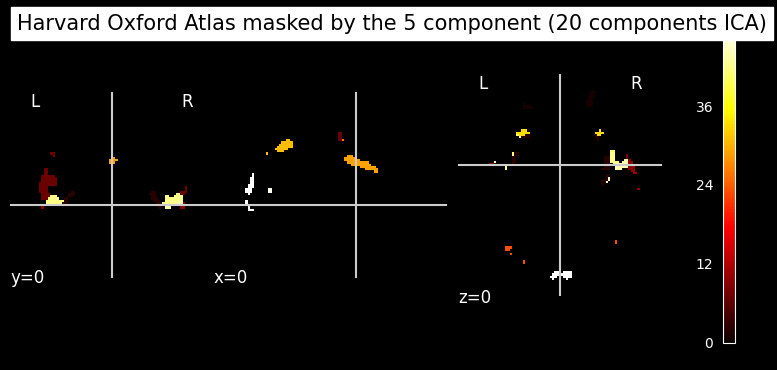

In [ ]:
threshold = 2*np.std(comp5)
comp5_region = comp5_bg_masked_resampled.get_fdata() > threshold
# Reduce the dimension of comp5_region to 3D
comp5_region_3D = comp5_region[..., 0]

data_tmp = atlas.maps.get_fdata()
# Set to zero all the regions that are not represented by the component
data_tmp[~comp5_region_3D] = 0

# Recreate an image for plotting and plot the image
tmp_img = nib.Nifti1Image(data_tmp, atlas.maps.affine)
plot_stat_map(tmp_img, title='Harvard Oxford Atlas masked by the 5 component (20 components ICA)',black_bg=True, colorbar=True, bg_img=dark_bg_img, display_mode='ortho', threshold=0.1, cut_coords=(0, 0, 0))

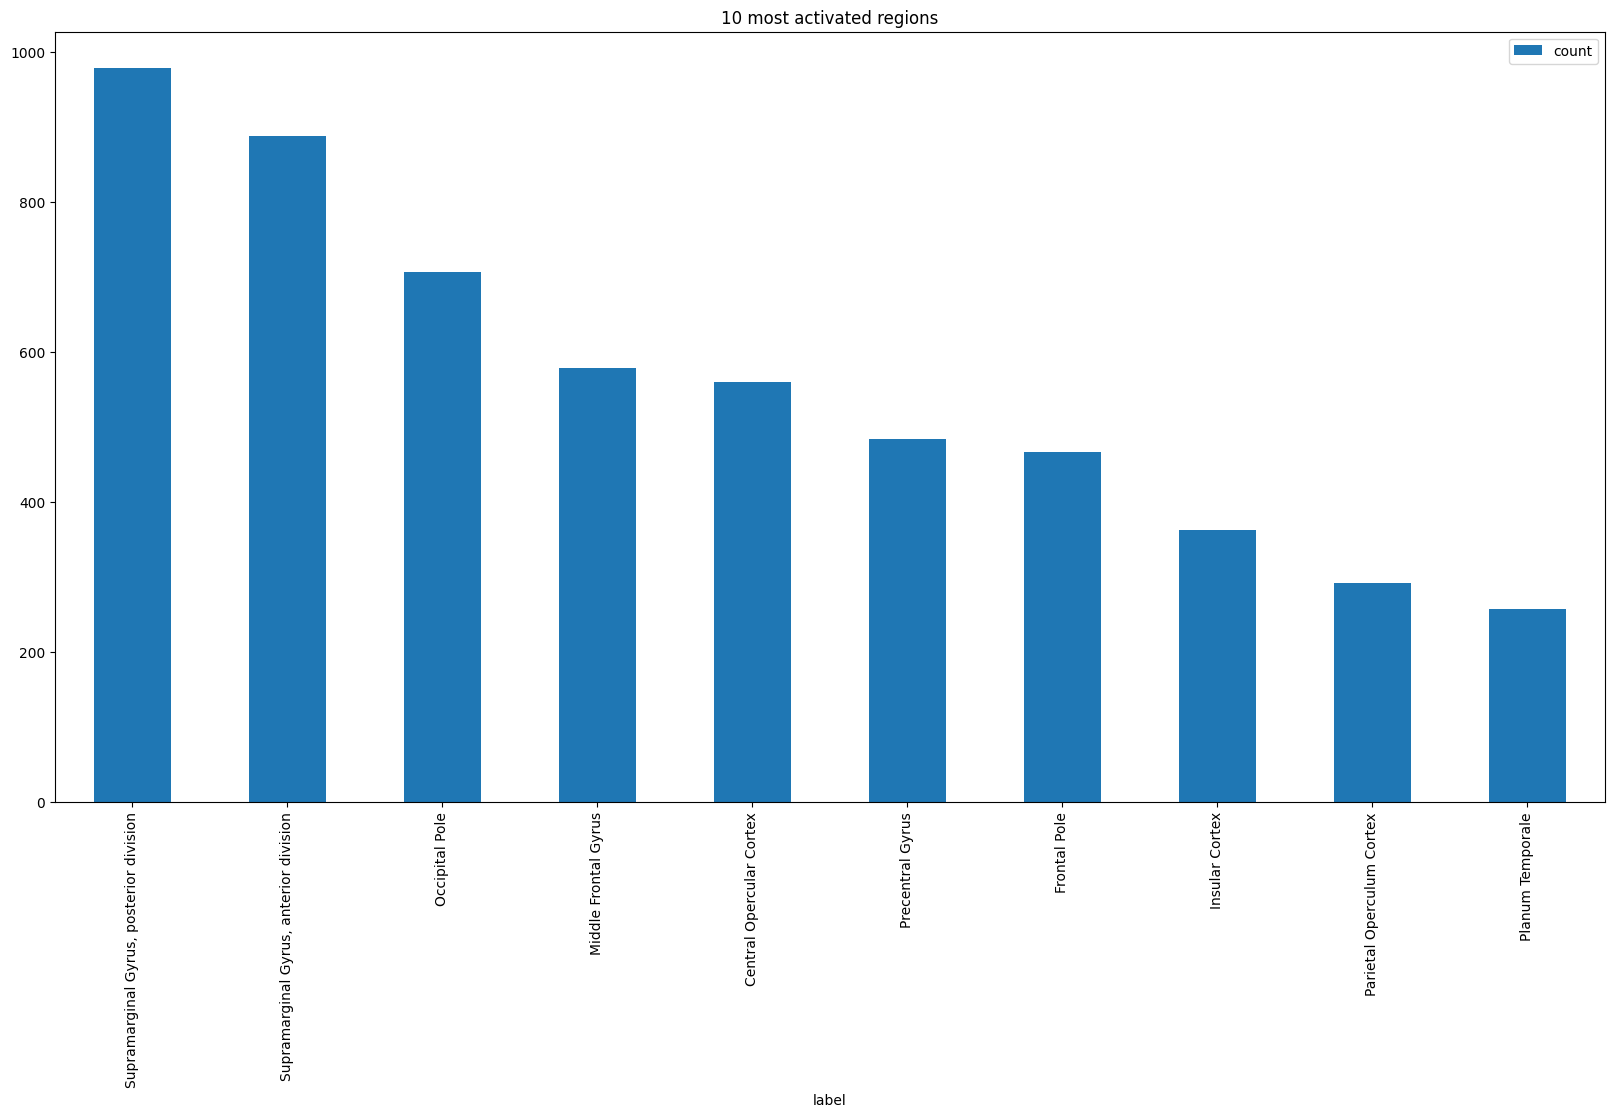

In [ ]:
# reduce data_tmp to 1D
data_tmp_1D = data_tmp.reshape(-1)

# print the different values in data_tmp_1D
labels = np.unique(data_tmp_1D)

# create a dataframe with labels as index and a column 'count' with the number of occurances of each label
df = pd.DataFrame(index=labels, columns=['count'])
# fill the dataframe with the number of occurences of each label
for label in labels:
    df.loc[label, 'count'] = np.sum(data_tmp_1D == label)

# create a dictionnary with the atlas labels and as keys their corresponding index in the atlas labels array
dict_labels = {}
for i in range(len(atlas.labels)):
    dict_labels[i] = atlas.labels[i]

df['label'] = df.index.map(dict_labels)

# sort the dataframe by the number of occurences of each label
df = df.sort_values(by='count', ascending=False)

# discard the first row, which is the background
df = df.iloc[1:]

# plot the 10 most activated regions in a bar plot
df.head(10).plot.bar(x='label', y='count', figsize=(20, 10), title='10 most activated regions')
plt.show()

#### Small analysis of the three main brain regions 
Supramarginal Gyrus --> activated for phonological processing during both language and verbal working memory tasks

Occipital pole --> visual processing

Middle frontal gyrus --> plays a key role in the development of literacy skills


In [ ]:
# Show the timecourse of the 10 most activated regions
nb_comp_timecourse = 10

S_ = S_dict[40].copy()

associated_timecourse = list()

for cidx in range(nb_comp_timecourse):
    threshold = np.std(S_[:, cidx])
    s_comp = np.reshape(S_[:, cidx], (x, y, z))
    thresh_mask = s_comp > threshold
    
    t_comp = X.reshape(N_tot, x, y, z)[:, thresh_mask].mean(axis=1)
    associated_timecourse.append(t_comp)

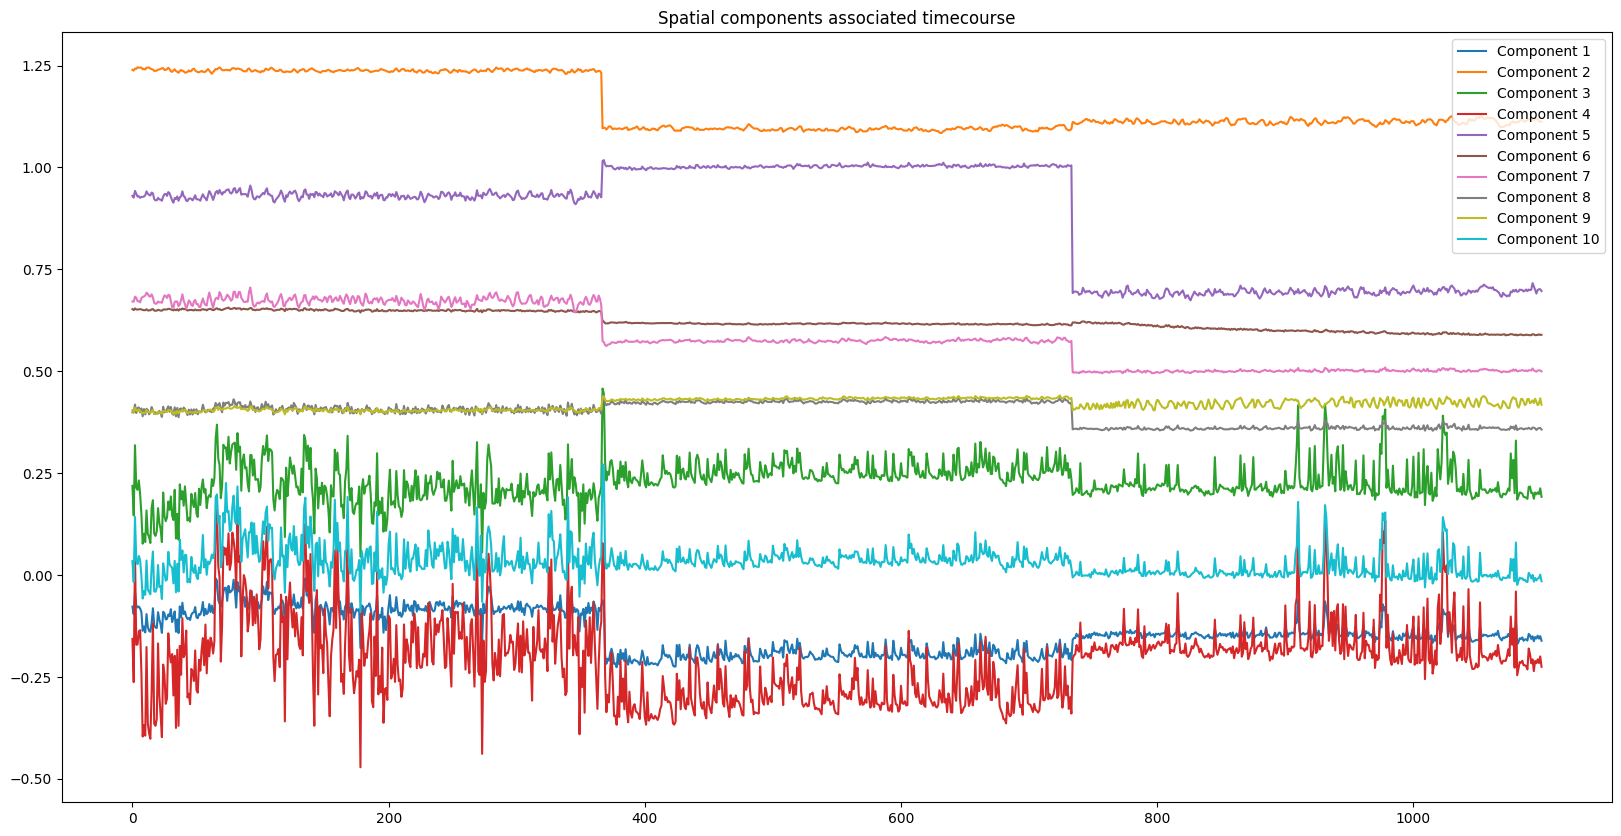

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 10))
for cidx in range(nb_comp_timecourse):
    ax.plot(associated_timecourse[cidx], label='Component %d'%(cidx+1))
    
ax.legend()
ax.set_label('TR')
ax.set_title('Spatial components associated timecourse')
plt.show()

If it looks like noise it is probably noise and can be used to denoise the data

# Seed analysis

In [ ]:
# Get data from the first subject
current_directory = os.getcwd()
individual = ('18','22','23', '24', '26', '28', '30', '31', '35', '36')
img = []
data = None
for i in range(3): # Change here the number of subjects you want to average. You may need to download the data beforehand
    print('Loading subject ', i+1)
    img.append(nib.load(current_directory + '/sub_'+individual[i] +'/derivatives/sub-'+individual[i]+'_task-alice_bold_preprocessed.nii.gz'))
    affine = img[i].affine
    
    temp = np.asanyarray(img[i].dataobj)
    temp = np.expand_dims(temp[...,5:], axis=-1)
    if data is None:
        data = temp
    else:
        # Remove first 5 volumes because they are some weird artifacts
        data = np.concatenate([data,temp], axis=-1)
icbms = datasets.fetch_icbm152_2009()
masker = NiftiMasker(mask_img=icbms.mask)
T1_img = icbms.t1
data = np.mean(data, axis=-1)



In [ ]:
def compute_pearson(voxel_coords):
    voxel_time_series = []
    vector_real = []
    masked = []
    pearson_coeffs_list = []
    for i in range(len(voxel_coords)):
        voxel_time_series.append(data[voxel_coords[i][0], voxel_coords[i][1], voxel_coords[i][2], :])
        vector_coord = np.array([voxel_coords[i][0], voxel_coords[i][1], voxel_coords[i][2], 1])
        vector_real.append(affine.dot(vector_coord))
        
        pearson_coeffs = np.zeros(data.shape[:-1])

        # Go through all the voxels and compute the Pearson correlation coefficient
        for x in range(data.shape[0]):
            for y in range(data.shape[1]):
                for z in range(data.shape[2]):
                    pearson_coeffs[x, y, z] = np.corrcoef(voxel_time_series[i], data[x, y, z, :])[0, 1]
        
        s_img = nib.Nifti1Image(pearson_coeffs, affine)
        data_to_show = masker.fit_transform(s_img)
        masked.append(masker.inverse_transform(data_to_show))
        pearson_coeffs_list.append(pearson_coeffs)
    
    return voxel_time_series, vector_real, masked, pearson_coeffs_list

In [ ]:
voxel_coords = ([11, 55, 36],
                [66, 51, 35],
                [52, 54, 15],
                [29, 52, 13],
                [50, 39, 18])
voxel_time_series, vector_real, masked, pearson_coeffs_list = compute_pearson(voxel_coords)
std_list = []
for i in range(len(pearson_coeffs_list)):
    std_list.append(np.nanstd(pearson_coeffs_list[i])*2)

There is twice the same cell. This is for you to compare between 1 subject, or an average of multiple ones, if you'd like to do this.

In [ ]:
import ipywidgets as widgets
from ipywidgets import interactive, fixed

def plot_pearson(threshold1, threshold2, threshold3, threshold4, threshold5, voxel_coords, cortex_names, voxel_time_series, vector_real, masked):
    _, axes = plt.subplots(nrows=len(voxel_coords), ncols=2, figsize=(35, 18))
    
    thresholds = [threshold1, threshold2, threshold3, threshold4, threshold5] 
    
    for i in range(len(voxel_coords)):
        axes[i, 0].plot(voxel_time_series[i])
        axes[i, 0].set_xlabel("Volume number")
        axes[i, 0].set_ylabel("Signal intensity")
        axes[i, 0].set_title("Time series for voxel ({}, {}, {})".format(*voxel_coords[i]))
        
        plot_stat_map(
            masked[i],
            title='Pearson correlation coefficient for {}, with a threshold of {:.2f}'.format(cortex_names[i], thresholds[i]),
            axes=axes[i, 1],
            black_bg=True,
            colorbar=True,
            bg_img=T1_img,
            display_mode='ortho',
            threshold=thresholds[i],  
            cut_coords=vector_real[i][:3]
        )


cortex_names = ['Right auditory cortex',
                'Left auditory cortex',
                'Amygdala',
                'Parahippocampal Gyrus, anterior division',
                'Parahippocampal Gyrus, posterior division']

# problème, c'est pas dynamique et j'arrive pas à les mettre dans une liste sans avoir d'erreur
threshold_slider1 = widgets.FloatSlider(min=0, max=.99, step=0.01, value=std_list[0], description='Threshold for '+cortex_names[0])
threshold_slider2 = widgets.FloatSlider(min=0, max=.99, step=0.01, value=std_list[1], description='Threshold for '+cortex_names[1])
threshold_slider3 = widgets.FloatSlider(min=0, max=.99, step=0.01, value=std_list[2], description='Threshold for '+cortex_names[2])
threshold_slider4 = widgets.FloatSlider(min=0, max=.99, step=0.01, value=std_list[3], description='Threshold for '+cortex_names[3])
threshold_slider5 = widgets.FloatSlider(min=0, max=.99, step=0.01, value=std_list[4], description='Threshold for '+cortex_names[4])


interactive_plot = interactive(
    plot_pearson,
    threshold1=threshold_slider1,
    threshold2=threshold_slider2,
    threshold3=threshold_slider3,
    threshold4=threshold_slider4,
    threshold5=threshold_slider5,
    
    voxel_coords=fixed(voxel_coords),  
    cortex_names=fixed(cortex_names),
    voxel_time_series=fixed(voxel_time_series),
    vector_real=fixed(vector_real),
    masked=fixed(masked)
)

interactive_plot

c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\nilearn\image\resampling.py:663: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(


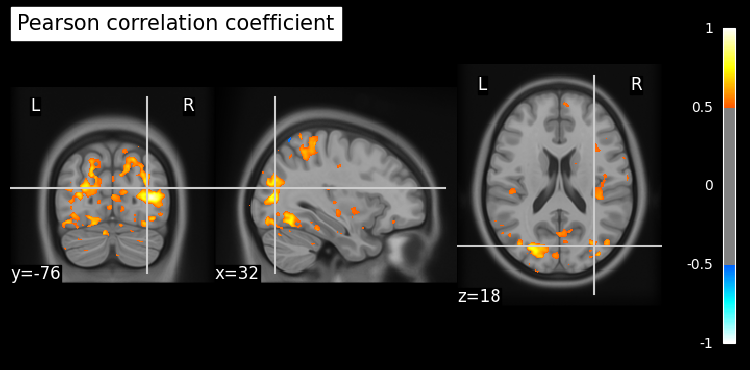

In [ ]:
import ipywidgets as widgets
from ipywidgets import interactive, fixed

def plot_pearson(threshold1, threshold2, threshold3, threshold4, threshold5, voxel_coords, cortex_names, voxel_time_series, vector_real, masked):
    _, axes = plt.subplots(nrows=len(voxel_coords), ncols=2, figsize=(35, 18))
    
    thresholds = [threshold1, threshold2, threshold3, threshold4, threshold5] 
    
    for i in range(len(voxel_coords)):
        axes[i, 0].plot(voxel_time_series[i])
        axes[i, 0].set_xlabel("Volume number")
        axes[i, 0].set_ylabel("Signal intensity")
        axes[i, 0].set_title("Time series for voxel ({}, {}, {})".format(*voxel_coords[i]))
        
        plot_stat_map(
            masked[i],
            title='Pearson correlation coefficient for {}, with a threshold of {:.2f}'.format(cortex_names[i], thresholds[i]),
            axes=axes[i, 1],
            black_bg=True,
            colorbar=True,
            bg_img=T1_img,
            display_mode='ortho',
            threshold=thresholds[i],  
            cut_coords=vector_real[i][:3]
        )


cortex_names = ['Right auditory cortex',
                'Left auditory cortex',
                'Amygdala',
                'Parahippocampal Gyrus, anterior division',
                'Parahippocampal Gyrus, posterior division']

# problème, c'est pas dynamique et j'arrive pas à les mettre dans une liste sans avoir d'erreur
threshold_slider1 = widgets.FloatSlider(min=0, max=.99, step=0.01, value=std_list[0], description='Threshold for '+cortex_names[0])
threshold_slider2 = widgets.FloatSlider(min=0, max=.99, step=0.01, value=std_list[1], description='Threshold for '+cortex_names[1])
threshold_slider3 = widgets.FloatSlider(min=0, max=.99, step=0.01, value=std_list[2], description='Threshold for '+cortex_names[2])
threshold_slider4 = widgets.FloatSlider(min=0, max=.99, step=0.01, value=std_list[3], description='Threshold for '+cortex_names[3])
threshold_slider5 = widgets.FloatSlider(min=0, max=.99, step=0.01, value=std_list[4], description='Threshold for '+cortex_names[4])


interactive_plot = interactive(
    plot_pearson,
    threshold1=threshold_slider1,
    threshold2=threshold_slider2,
    threshold3=threshold_slider3,
    threshold4=threshold_slider4,
    threshold5=threshold_slider5,
    
    voxel_coords=fixed(voxel_coords),  
    cortex_names=fixed(cortex_names),
    voxel_time_series=fixed(voxel_time_series),
    vector_real=fixed(vector_real),
    masked=fixed(masked)
)

interactive_plot

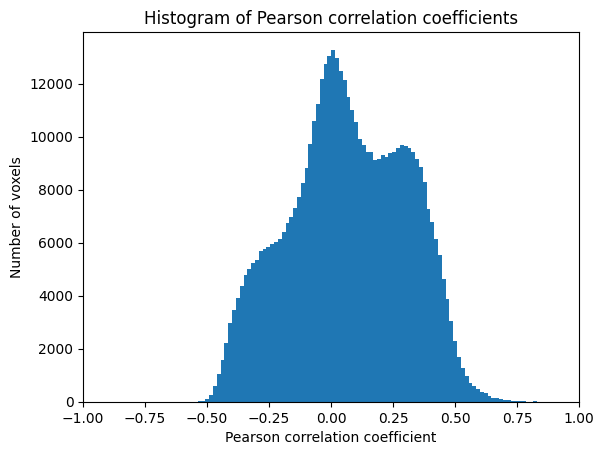

In [ ]:
# Plot the histogram of the Pearson correlation coefficients
plt.subplot(nrows = len(pearson_coeffs_list), ncols = 1, figsize=(20, 10))
for i in range(len(pearson_coeffs_list)):
    plt.hist(pearson_coeffs_list[i].reshape(-1), bins=100) # reshape to 1D for histogram plotting
    plt.xlabel("Pearson correlation coefficient for {}".format(cortex_names[i]))
    plt.ylabel("Number of voxels")
    plt.title("Histogram of Pearson correlation coefficients")
    plt.xlim(-1, 1)
plt.show()

### BONUS, Task 5

Solved by following this steps:

1) Take the data of one patient, resample each volume to the size of the atlas, choose 10 regions

2)  For each region, take the voxels of the volume that are in the region and compute the mean of the voxels, get a matrix of 10x367

3) Compute the correlation matrix of this matrix and its adjacency matrix. The adjacency matrix is obtained by changing the diagonal coefficients to 0 (serie 6). 

4) plotting


In [ ]:
patient_18_data_reshaped_atlas = []
for vol in tqdm(range(data.shape[-1])):
    temp_data = nib.Nifti1Image(data[..., vol], affine)
    temp_data_masked = masker.fit_transform(temp_data)
    temp_data_masked = masker.inverse_transform(temp_data_masked)
    temp_data_masked_resampled = image.resample_img(temp_data_masked, target_affine=atlas.maps.affine, target_shape=atlas.maps.shape)
    patient_18_data_reshaped_atlas.append(temp_data_masked_resampled.get_fdata())

  0%|          | 0/372 [00:00<?, ?it/s]c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\nilearn\image\resampling.py:591: UserWarning: Casting data from int16 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
  0%|          | 1/372 [00:04<27:17,  4.41s/it]c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(

In [ ]:
patient_18_data_reshaped_atlas = np.array(patient_18_data_reshaped_atlas)

In [ ]:
# Take the 10 region from the previous ICA
number_of_regions = 10
df = df.head(number_of_regions)

In [ ]:
time_series_matrix = np.zeros((number_of_regions, patient_18_data_reshaped_atlas.shape[0]))
time_series_matrix.shape

(10, 372)

In [ ]:
for idx in range(number_of_regions):
    region = int(df.index[idx])
    print("Computing region ", region, "({})".format(df.iloc[idx]['label']))
    # Get the region of interest
    roi = atlas.maps.get_fdata() == region
    # Compute the mean of the time series for each volume
    for volume in tqdm(range(patient_18_data_reshaped_atlas.shape[0])):
        # transform patient_18_data_reshaped_atlas[volume] into a 3D array
        patient_18_data_reshaped_atlas_3D = patient_18_data_reshaped_atlas[volume][..., 0].copy()
        # Compute the mean of the time series for each region
        time_series_matrix[idx, volume] = np.mean(patient_18_data_reshaped_atlas_3D[roi])

Computing region  20 (Supramarginal Gyrus, posterior division)


100%|██████████| 372/372 [00:01<00:00, 227.35it/s]


Computing region  19 (Supramarginal Gyrus, anterior division)


100%|██████████| 372/372 [00:01<00:00, 247.02it/s]


Computing region  48 (Occipital Pole)


100%|██████████| 372/372 [00:01<00:00, 264.39it/s]


Computing region  4 (Middle Frontal Gyrus)


100%|██████████| 372/372 [00:01<00:00, 241.22it/s]


Computing region  42 (Central Opercular Cortex)


100%|██████████| 372/372 [00:01<00:00, 257.94it/s]


Computing region  7 (Precentral Gyrus)


100%|██████████| 372/372 [00:01<00:00, 252.91it/s]


Computing region  1 (Frontal Pole)


100%|██████████| 372/372 [00:01<00:00, 241.74it/s]


Computing region  2 (Insular Cortex)


100%|██████████| 372/372 [00:01<00:00, 227.07it/s]


Computing region  43 (Parietal Operculum Cortex)


100%|██████████| 372/372 [00:01<00:00, 222.95it/s]


Computing region  46 (Planum Temporale)


100%|██████████| 372/372 [00:01<00:00, 238.64it/s]


In [78]:
# drop the first 5 volumes because they are artifacts
time_series_matrix = time_series_matrix[:, 5:]

# plot the time series for the 10 regions of interest
plt.figure(figsize=(20, 10))
for idx in range(number_of_regions):
    plt.plot(time_series_matrix[idx], label=df.iloc[idx]['label'])
plt.legend()
plt.xlabel("Volume number")
plt.ylabel("Signal intensity")
plt.title("Time series for the 10 regions of interest")
plt.show()

NameError: name 'time_series_matrix' is not defined

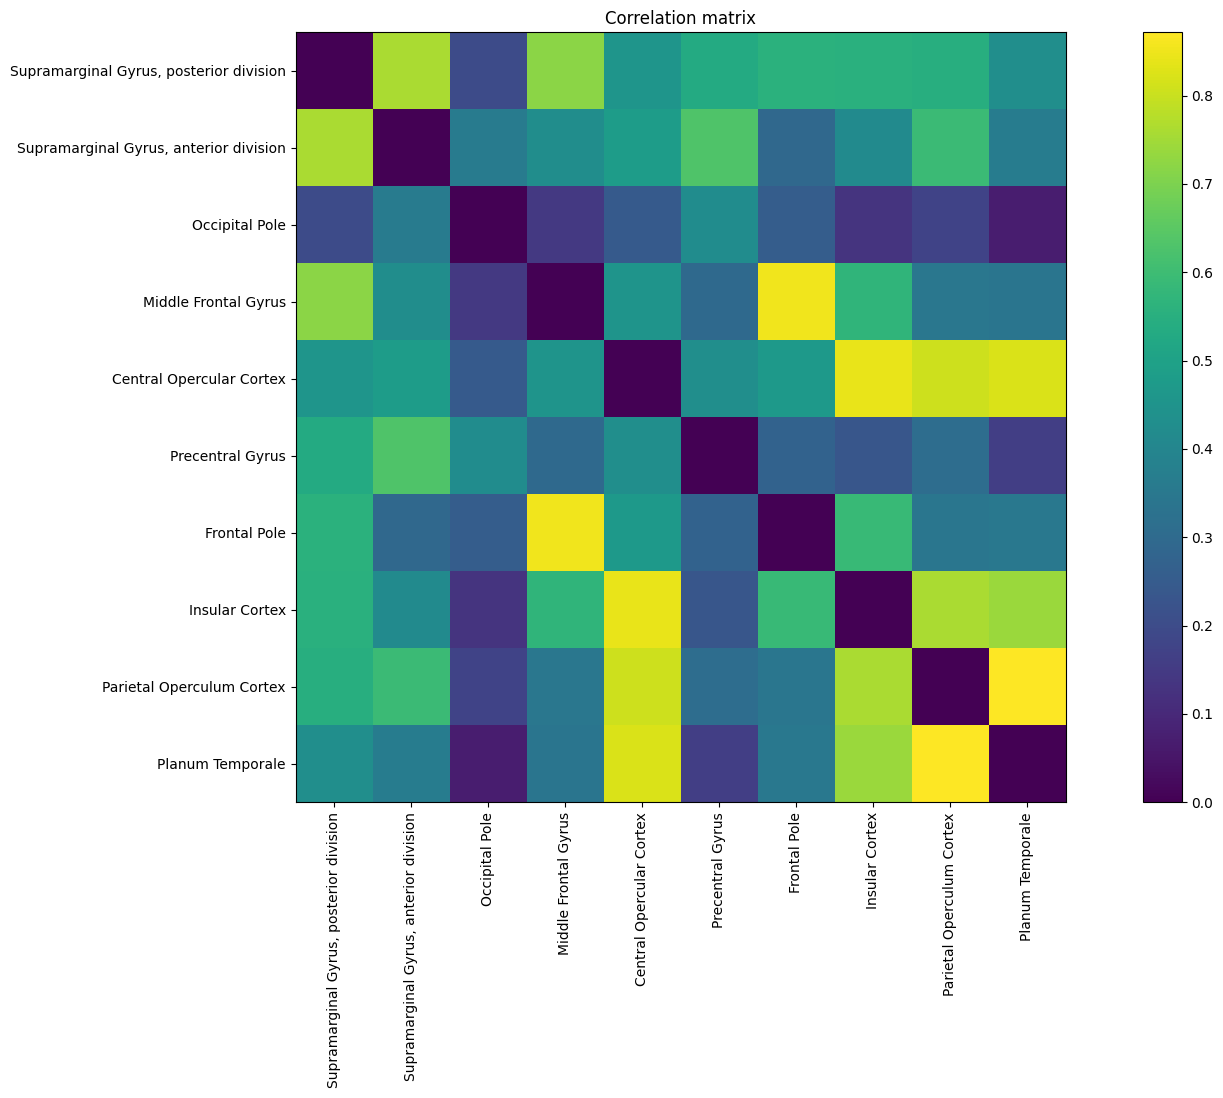

In [64]:
# compute the correlation matrix
correlation_matrix = np.corrcoef(time_series_matrix)

# set the diagonal to 0
np.fill_diagonal(correlation_matrix, 0)

# plot the correlation matrix
plt.figure(figsize=(20, 10))
plt.imshow(correlation_matrix)
plt.colorbar()
plt.title("Correlation matrix")
plt.xticks(np.arange(0, number_of_regions), df['label'].values, rotation=90)
plt.yticks(np.arange(0, number_of_regions), df['label'].values)
plt.show()


In [65]:
# write the correlation matrix in a csv file
df = pd.DataFrame(correlation_matrix)
df.to_csv('correlation_matrix.csv', index=False, header=False)
